## Build a model from Python

In this example a simple **SFINCS** compound flood model will be made, using the underlying Python functions of **HydroMT-SFINCS** to build a model.

The model is situated in **Northern Italy**, where a small selection of topography and bathymetry data has already been made available for you to try the examples.

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd

from hydromt_sfincs import SfincsModel
from hydromt_sfincs import utils
from pathlib import Path

This example shows how to build a SFINCS model containing elevation data and spatially varying roughness (together processed into subgrid tables), spatially varying infiltration and a local floodwall. In addition, multiple forcing conditions are set-up, and this is all done using Python scripting.

In case you want to adjust this example to build a SFINCS model anywhere else in the world, you will have to add your own datasets to HydroMT's data catalog. For more info on that, check-out:

- [Prepare data catalog](https://deltares.github.io/hydromt/latest/user_guide/data_prepare_cat.html)

- [Example: Prepare data catalog](https://deltares.github.io/hydromt/latest/_examples/prep_data_catalog.html)

- [Example: Datasources](example_datasources.ipynb)

**Steps followed in this notebook to build your SFINCS model:**
<ol> 
<li> Open SfincsModel class, set data library and output folder </li>
<li> Specify characteristics of the wanted grid </li>
<li> Load in wanted elevation datasets </li>
<li> Make mask of active and inactive cells </li>
<li> Update mask with water level and outflow boundary cells</li>
<li> Add spatially varying roughness data</li>
<li> Make subgrid derived tables</li>
<li> Add spatially varying infiltration data</li>
<li> Add water level time-series as forcing</li>
<li> Add an upstream discharge time-series as forcing</li>
<li> Add spatially varying rainfall data</li>
<li> Add weirfile</li>
<li> Add observation points</li>
<li> Add observation lines</li>
<li> Show model</li>
<li> Save all files</li>
</ol> 

Let's get started!

### 1. Initialize SfincsModel class, set data library and output folder:

In [2]:
# Initialize SfincsModel Python class with the artifact data catalog which contains publically available data for North Italy
# we overwrite (mode='w+') the existing model in the root directory if it exists
sf = SfincsModel(data_libs=["artifact_data"], root="tmp_sfincs_compound", mode="w+")

Model dir already exists and files might be overwritten: c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\hydromt-0.9.4\examples_sfincs\tmp_sfincs_compound\gis.


### 2. Specify characteristics of the wanted grid and generate grid:

For more info about how to define a grid, [click here](https://sfincs.readthedocs.io/en/latest/input.html#grid-characteristics). 

*Hint: if you only have a bounding box or geometry, you can also use `SfincsModel.setup_grid_from_region`.*

In [3]:
# Specify an input dictionary with the grid settings x0,y0,dx,dy,nmax,mmax,rotation and epsg code.
# create SFINCS model with regular grid and characteristics of the input dictionary:
sf.setup_grid(
    x0=318650,
    y0=5040000,
    dx=50.0,
    dy=50.0,
    nmax=107,
    mmax=250,
    rotation=27,
    epsg=32633,
)

# Alternatively, we can also use a shape/geojson file to define the grid:
# sf.setup_grid_from_region(
#     region = {'geom': 'data/region.geojson'},
#     res= 50,
#     rotated=True,
#     crs=32633
# )

# the input file is automatically updated. Uncomment to displayed below:
print(sf.config)

{'mmax': 250, 'nmax': 107, 'dx': 50.0, 'dy': 50.0, 'x0': 318650, 'y0': 5040000, 'rotation': 27, 'latitude': 0.0, 'tref': datetime.datetime(2010, 2, 1, 0, 0), 'tstart': datetime.datetime(2010, 2, 1, 0, 0), 'tstop': datetime.datetime(2010, 2, 2, 0, 0), 'tspinup': 60.0, 'dtout': 3600.0, 'dthisout': 600.0, 'dtrstout': 0.0, 'dtmaxout': 86400, 'trstout': -999.0, 'dtwnd': 1800.0, 'alpha': 0.5, 'theta': 1.0, 'huthresh': 0.01, 'manning': 0.04, 'manning_land': 0.04, 'manning_sea': 0.02, 'rgh_lev_land': 0.0, 'zsini': 0.0, 'qinf': 0.0, 'rhoa': 1.25, 'rhow': 1024.0, 'dtmax': 60.0, 'advection': 1, 'baro': 0, 'pavbnd': 0, 'gapres': 101200.0, 'stopdepth': 100.0, 'crsgeo': 0, 'btfilter': 60.0, 'viscosity': 1, 'inputformat': 'bin', 'outputformat': 'net', 'cdnrb': 3, 'cdwnd': [0.0, 28.0, 50.0], 'cdval': [0.001, 0.0025, 0.0015], 'epsg': 32633}


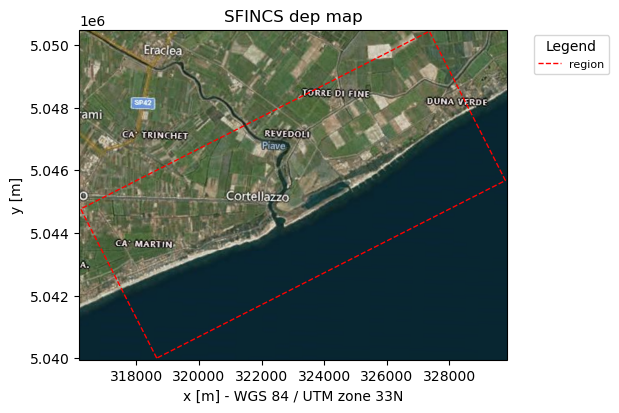

In [4]:
# show the model grid outline
# sf.region.boundary.plot(figsize=(6,6))
_ = sf.plot_basemap(plot_region=True, bmap="sat", zoomlevel=12)

### 3. Load in wanted elevation datasets:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


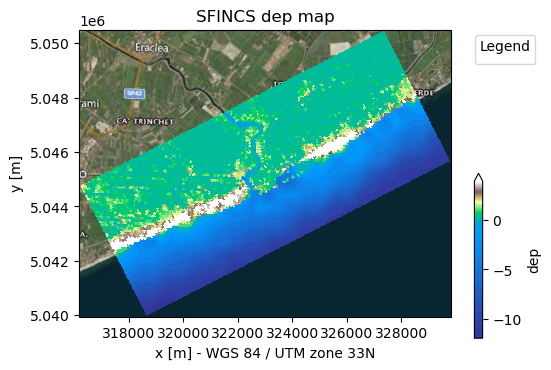

In [5]:
# In this example we want to combine 2 elevation datasets, merit_hydro as elevation and gebco as bathymetry, in that order.

# NOTE: from the 1st dataset (merit_hydro) only elevation above ("zmin":0.001) meters is used;
# the 2nd elevation dataset (gebco) is used where the 1st dataset returned nodata values
datasets_dep = [{"elevtn": "merit_hydro", "zmin": 0.001}, {"elevtn": "gebco"}]

# Add depth information to modelgrid based on these chosen datasets
dep = sf.setup_dep(datasets_dep=datasets_dep)

# Make a plot of the merged topobathy, here colour limits are set between an elevation of -5 to 5 meters
_ = sf.plot_basemap(variable="dep", bmap="sat", zoomlevel=12)

### 4. Make mask of active and inactive cells:

Here we generate the mask of active (msk=1) and inactive cells (msk=0), determining what cells on your grid should be used. 
For more info about the msk-file, [click here](https://sfincs.readthedocs.io/en/latest/input.html#mask-file). 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


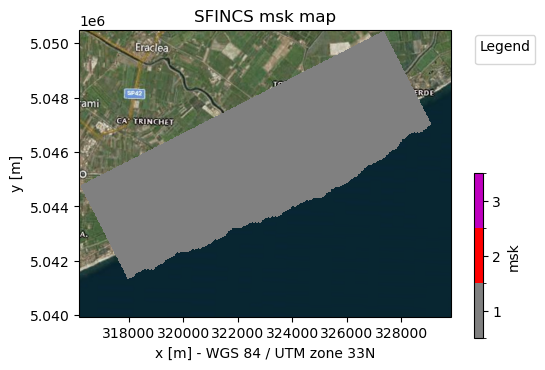

In [6]:
# Choosing how to choose you active cells can be based on multiple criteria, here we only specify a minimum elevation of -5 meters
sf.setup_mask_active(zmin=-5, reset_mask=True)

# Make a plot of the mask file
_ = sf.plot_basemap(variable="msk", plot_bounds=True, bmap="sat", zoomlevel=12)

NOTE:
- The given output of HydroMT says "3 gaps outside valid elevation range < 10 km2". 
HydroMT does some smart filtering that if small groups of inactive cells are found, surrounded by active cells, these are still included as active, in this case 3 gaps.
You can control the size of these gaps to filter by adding `fill_area = 10` in `setup_mask_active()`.
- A similar argument exists to neglect a group of active cells surrounded by inactive cells: `drop_area`
- `reset_mask=True` means that every time you start with an ampy mask while defining your msk cells, if `reset_bounds=False` (default) you continue on the prevous time you ran that function

### 5. Update mask with water level and outflow boundary cells - including use of polygons:

In [7]:
# Loading a shapefile clicked by user:
file_name = Path("data//compound_example_outflow_boundary_polygon.geojson")
gdf_include = sf.data_catalog.get_geodataframe(file_name)

# Example of the same, but how to load an existing ascii .pol file with x&y-coordinates, e.g. coming out of Delft Dashboard, here assumed to be in the CRS of the SFINCS model:
# file_name = "XX.pol"
# gdf_include = utils.polygon2gdf(feats=utils.read_geoms(fn=file_name), crs=sf.crs)

In SFINCS you can specify cells where you want to force offshore water levels (msk=2), or outflow boundaries (msk=3)

<GeoAxes: title={'center': 'SFINCS msk map'}, xlabel='x [m] - WGS 84 / UTM zone 33N', ylabel='y [m]'>

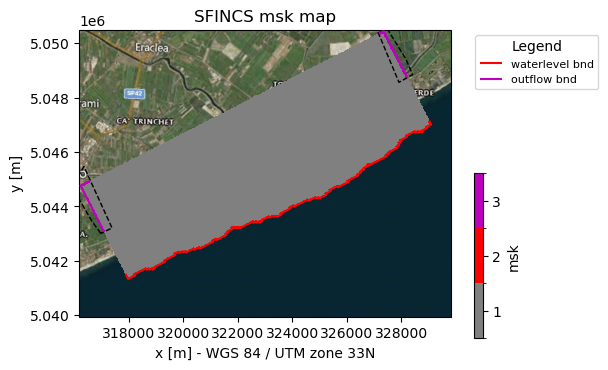

In [8]:
# Here we add water level cells along the coastal boundary, for cells up to an elevation of -5 meters
sf.setup_mask_bounds(btype="waterlevel", zmax=-5, reset_bounds=True)

# Here we add outflow cells, only where clicked in shapefile along part of the lateral boundaries
sf.setup_mask_bounds(btype="outflow", include_mask=gdf_include, reset_bounds=True)

# Make a plot of the mask file
fig, ax = sf.plot_basemap(variable="msk", plot_bounds=True, bmap="sat", zoomlevel=12)
gdf_include.to_crs(sf.crs).boundary.plot(
    ax=ax, color="k", lw=1, ls="--"
)  # plot the shapefile given by the user as dashed line

NOTE:
- As you can see now, also msk=2 values (red line) have been added along the coastal boundary
- As you can see now, also msk=3 values (purple line) have been added along the lateral inland boundaries within the gdf_include shapefile
- `reset_bounds=True` means that you start without initial boundary cells (of the specified type), if `reset_bounds=False` (default) you build on the existing boundary cells (if available)

### 6. Add river inflow points:

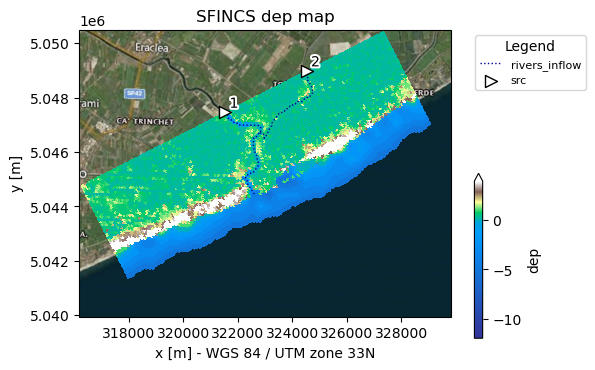

In [9]:
# derive river from hydrography data based on a minimum river length (river_len)
# and minimum upstream area (river_upa)

sf.setup_river_inflow(
    hydrography="merit_hydro", river_len=1000, river_upa=50, keep_rivers_geom=True
)

# Make a plot of model
# note the src points and derived river network
fig, ax = sf.plot_basemap(variable="dep", plot_bounds=False, bmap="sat", zoomlevel=12)

In [10]:
# --> this is used when the making subgrid tables (step 8)

# use the derived rivers to burn these into the model subgrid
# note that the width and depth are arbitrary here

gdf_riv = sf.geoms["rivers_inflow"].copy()
gdf_riv["rivwth"] = [100, 50, 50]  # width [m]
gdf_riv["rivdph"] = 1.5  # depth [m]
gdf_riv["manning"] = 0.03  # manning coefficient [s.m-1/3]
gdf_riv[["geometry", "rivwth", "rivdph", "manning"]]

# prepare the river dataset for the subgrid
# instead of using the derived rivers, you could also use an aribitrary shapefile with centerlines
# Other options include to add a river mask shapefile rather than a river width attribute
# Note that the width is either specified on the river centerline or with a river mask
# Also the river bed level (rivbed) can be specified instead of the river depth (rivdph).

datasets_riv = [{"centerlines": gdf_riv}]

### 7. Add spatially varying roughness data:

To ensure a correct lower roughness of the rivers in the domain, we 'burn in' the river with a lower manning roughness value. There is two different ways to do this:
<ol>
<li>Rasterize the manning value of gdf to the model grid and use this as a manning raster in datasets_rgh</li>
<li>Provide a manning roughness for datasets_riv while burning in rivers into the subgrid</li>
</ol>

In [11]:
# 1. rasterize the manning value of gdf to the  model grid and use this as a manning raster

# gdf_riv_buf = gdf_riv.assign(geometry=gdf_riv.buffer(gdf_riv['rivwth']/2))
# da_manning = sf.grid.raster.rasterize(gdf_riv_buf, "manning", nodata=np.nan)

# use the river manning raster in combination with vito land to derive the manning roughness file
# NOTE that we can combine in-memory data with data from the data catalog
# datasets_rgh = [{"manning": da_manning}, {"lulc": "vito"}]

# uncomment to plot either the raster or the vector data:
# da_manning.plot(vmin=0, x='xc', y='yc', cmap='viridis')
# gdf.plot()

In [12]:
# 2. provide the manning value to the datasets_riv and burn in the river with a lower manning value
# a global manning value can be provided to the datasets_riv, or a manning value per river segment can be provided
# NOTE when using this method, we don't need to provide the river manning values to the datasets_rgh
datasets_rgh = [{"lulc": "vito"}]

In [13]:
# NOTE This step can be skipped because we prepare a subgrid model,
# the manning roughness is than included in the subgrid tables
# For models without subgrid uncomment the following lines.

# sf.setup_manning_roughness(
#     datasets_rgh=datasets_rgh,
#     manning_land=0.04,
#     manning_sea=0.02,
#     rgh_lev_land=0,  # the minimum elevation of the land
# )
# _ = sf.plot_basemap(variable="manning", plot_bounds=False, bmap="sat", zoomlevel=12)

### 8. Make subgrid derived tables:

Subgrid derived tables are used to better capture the elevation and roughness of your domain, to either improve your results, or to allow you to run on a courser grid resolution (means faster simulation). For more info about subgrid tables, [click here](https://sfincs.readthedocs.io/en/latest/developments.html#recent-advancements-in-accuracy-subgrid-mode). 

You as user can specify multiple settings about how the subgrid derived tables should be made.

Every single grid cell of the flux grid of the size inp.dx by inp.dy is defined into subgrid pixels (default nr_subgrid_pixels = 20).
For every subgrid pixel the topobathy data is loaded, ideally this consists of high-resolution DEM datasets that you specify as user.

In this example with dx=dy=50m, having nr_subgrid_pixels = 20 means we are loading data onto a 2.5 m subpixel grid
However, the input data of Gebco and Merit_hydro is way coarser, therefore let's set the ratio to 5 for now.

In [14]:
# Every single grid cell of the flux grid of the size inp.dx by inp.dy is defined into subgrid pixels (default is 20, nr_subgrid_pixels = 20).
# For every subgrid pixel the topobathy data is loaded, ideally this consists also of high-resolution DEM datasets that you specify as user.

sf.setup_subgrid(
    datasets_dep=datasets_dep,
    datasets_rgh=datasets_rgh,
    datasets_riv=datasets_riv,
    nr_subgrid_pixels=5,
    write_dep_tif=True,
    write_man_tif=False,
)

# NOTE: we turned on that the merged topobathy of the different (high-res) datasets is written to a geotiff

# NOTE: if you have a very large domain with 100,000s to millions of cells, and very high-resolution datasets (e.g. 1 m), this step might take minutes to hours!!!
#       But good news; when finished succesfully, you can very quickly run very accurate SFINCS simulations!
#       The whole point of the subgrid functionality of SFINCS is that by derived subgrid tables based on high res elevation data,
#       you either have more accurate results or run on a coarser grid resolution (= much faster) or both

The nodata value None is not in the reclass table.None will be used for the params.


Now we can see what kind of subgrid-derived variables are created:

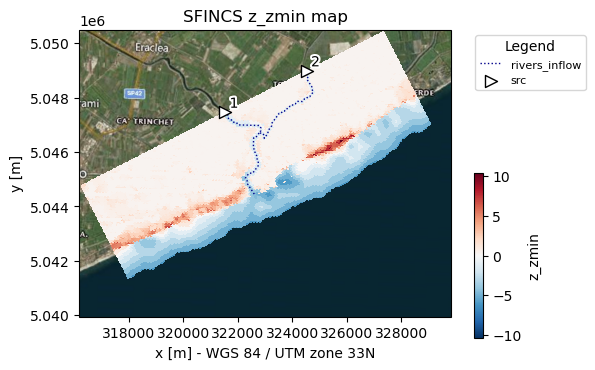

In [15]:
# uncomment to see the subgrid table variales
# sf.subgrid

# we can plot the 2D subgrid variables
_ = sf.plot_basemap(
    variable="subgrid.z_zmin", plot_bounds=False, bmap="sat", zoomlevel=12
)

### 9. Add spatially varying infiltration data:

In [16]:
# independent from subgrid files
# curve number infiltration based on global CN dataset
sf.setup_cn_infiltration("gcn250", antecedent_moisture="avg")

# check all variables in the sf.grid dataset
sf.grid.data_vars.keys()

KeysView(Data variables:
    dep      (y, x) float32 107kB -12.0 -12.0 -12.0 -12.0 ... 0.3 0.3 0.3 0.4
    msk      (y, x) uint8 27kB 0 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 3 3 3 3
    scs      (y, x) float64 214kB dask.array<chunksize=(107, 250), meta=np.ndarray>)

By now we have made all basic SFINCS spatial layers to make the mskfile, infiltrationfile and subgridfiles, now we're going to add some forcing...

### 10. Add water level time-series as forcing:

In [17]:
# Change period of model simulation time, specified in yyyymmdd HHMMSS --> simulation time here is 24 hours
sf.setup_config(
    **{
        "tref": "20100201 000000",
        "tstart": "20100205 000000",
        "tstop": "20100207 000000",
    }
)

print(sf.config)

{'mmax': 250, 'nmax': 107, 'dx': 50.0, 'dy': 50.0, 'x0': 318650, 'y0': 5040000, 'rotation': 27, 'latitude': 0.0, 'tref': '20100201 000000', 'tstart': '20100205 000000', 'tstop': '20100207 000000', 'tspinup': 60.0, 'dtout': 3600.0, 'dthisout': 600.0, 'dtrstout': 0.0, 'dtmaxout': 86400, 'trstout': -999.0, 'dtwnd': 1800.0, 'alpha': 0.5, 'theta': 1.0, 'huthresh': 0.01, 'manning': 0.04, 'manning_land': 0.04, 'manning_sea': 0.02, 'rgh_lev_land': 0.0, 'zsini': 0.0, 'rhoa': 1.25, 'rhow': 1024.0, 'dtmax': 60.0, 'advection': 1, 'baro': 0, 'pavbnd': 0, 'gapres': 101200.0, 'stopdepth': 100.0, 'crsgeo': 0, 'btfilter': 60.0, 'viscosity': 1, 'inputformat': 'bin', 'outputformat': 'net', 'cdnrb': 3, 'cdwnd': [0.0, 28.0, 50.0], 'cdval': [0.001, 0.0025, 0.0015], 'epsg': 32633, 'mskfile': 'sfincs.msk', 'indexfile': 'sfincs.ind', 'sbgfile': 'sfincs.sbg', 'scsfile': 'sfincs.scs'}


**a. Specify water level input locations:**

For more info about what the bndfile is, [click here](https://sfincs.readthedocs.io/en/latest/input_forcing.html#water-level-points)

In [18]:
# Here we specify at what x&y-locations we have measured/modelled input water level data in the bndfile of SFINCS:

# x&y-locations in same coordinate reference system as the grid:
x = [319526, 329195]
y = [5041108, 5046243]

# add to Geopandas dataframe as needed by HydroMT
pnts = gpd.points_from_xy(x, y)
index = [1, 2]  # NOTE that the index should start at one
bnd = gpd.GeoDataFrame(index=index, geometry=pnts, crs=sf.crs)

# show what has been created:
display(bnd)

,geometry
1,POINT (319526.000 5041108.000)
2,POINT (329195.000 5046243.000)


**b. Make up some time-series:**

For more info about what the bzsfile is, [click here](https://sfincs.readthedocs.io/en/latest/input_forcing.html#water-level-time-serie)

In [19]:
# Here we specify at what times we are providing water level input, and afterwards what the values are per input location:

# In this case we will provide 3 values (periods=3) between the start (tstart=20100201 000000) and the end (tstop=20100201 120000) of the simulation:
time = pd.date_range(
    start=utils.parse_datetime(sf.config["tstart"]),
    end=utils.parse_datetime(sf.config["tstop"]),
    periods=3,
)

# and the actual water levels, in this case for input location 1 a water level rising from 0 to 2 meters and back to 0:
bzs = [[0, 0.25], [0.75, 1.0], [0, 0.25]]

bzspd = pd.DataFrame(index=time, columns=index, data=bzs)
display(bzspd)

,1,2
2010-02-05,0.00,0.25
2010-02-06,0.75,1.00
2010-02-07,0.00,0.25


In [20]:
# Actually add it to the SFINCS model class:
sf.setup_waterlevel_forcing(timeseries=bzspd, locations=bnd)

# NOTE: the waterlevel forcing data is now stored in the sf.forcing dictionary
sf.forcing.keys()

dict_keys(['dis', 'bzs'])

### 11. Add an upstream discharge time-series as forcing:

**a. specify discharge input locations: srcfile**

For more info about what the srcfile is, [click here](https://sfincs.readthedocs.io/en/latest/input_forcing.html#discharge-points)

**b. specify discharge time-series: disfile**

For more info about what the disfile is, [click here](https://sfincs.readthedocs.io/en/latest/input_forcing.html#discharge-time-series)

In [21]:
# We now use the previously created src discharge points (step 6)
# Alternativly you can also create a new geodataframe with points, similar to the water level forcing points

# make up some discharge data
index = sf.forcing["dis"].index
dis = np.array([[2.0, 1.0], [5.0, 2.0], [2.0, 1.0]])
dispd = pd.DataFrame(index=time, columns=index, data=dis)

# now we call the function setup_discharge_forcing, which adds the discharge forcing to the src points
sf.setup_discharge_forcing(timeseries=dispd)

# # NOTE: the discharge forcing data is now stored in the sf.forcing dictionary
sf.forcing.keys()

dict_keys(['dis', 'bzs'])

In case you want to add other types of forcing, see the example notebook example_forcing.ipynb for other types.
Or read more about this in the [SFINCS manual](https://sfincs.readthedocs.io/en/latest/input_forcing.html)

### 12. Add spatially varying rainfall data:

In [22]:
# hourly rainfall rates of ECMWF' ERA5 data for the specific area and period have been made available for this period in the artefact data
sf.setup_precip_forcing_from_grid(precip="era5_hourly", aggregate=False)

# NOTE: the precipitation forcing data is now stored in the sf.forcing dictionary
sf.forcing.keys()

dict_keys(['dis', 'bzs', 'precip_2d'])

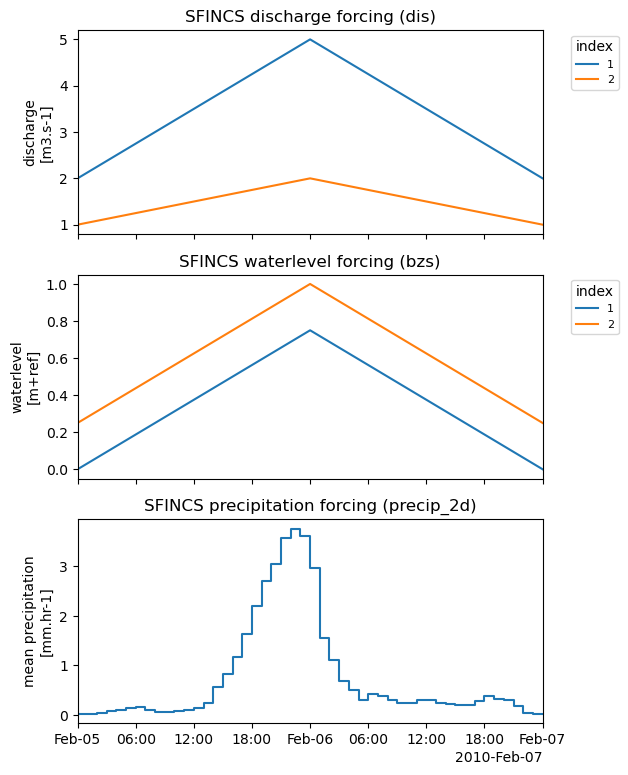

In [23]:
# Plot combined forcing time-series:
_ = sf.plot_forcing(fn_out="forcing.png")

### 13. Add weirfile:
In SFINCS, a weirfile is often used to explicity account for line-element features such as dikes, dunes or floodwalls. Read more about structures in the [SFINCS manual](https://sfincs.readthedocs.io/en/latest/input_structures.html)

In [24]:
# In this example specify a 'line' style shapefile for the location of the weir to be added
# NOTE: optional: dz argument - If provided, for weir structures the z value is calculated from the model elevation (dep) plus dz.
sf.setup_structures(
    structures=Path(r"data/compound_example_weirfile_input.geojson"),
    stype="weir",
    dz=None,
)

# NOTE: the observation points are now stored in the sf.geoms dictionary
sf.geoms.keys()

dict_keys(['region', 'rivers_inflow', 'weir'])

### 14. Add observation points:

For more info about what the obsfile is, [click here](https://sfincs.readthedocs.io/en/latest/input.html#observation-points)

In [25]:
# Loading a point shapefile clicked by user:
# NOTE: merge=True makes HydroMT merge the new observation points with already existing observation points (if present)
sf.setup_observation_points(
    locations=Path(r"data/compound_example_observation_points.geojson"), merge=True
)

# NOTE: the observation points are now stored in the sf.geoms dictionary
sf.geoms.keys()

dict_keys(['region', 'rivers_inflow', 'weir', 'obs'])

### 14. Add observation lines:

Observation lines (cross-sections) can be added to monitor discharges through cross-sections. For more info about what the crsfile is, [click here](https://sfincs.readthedocs.io/en/latest/input.html#cross-sections-for-discharge-output)


In [26]:
# Loading a LineString GeoJson clicked by user:
sf.setup_observation_lines(
    locations=Path(r"data/compound_example_observation_lines.geojson"), merge=True
)

# NOTE: the observation lines are now stored in the sf.geoms dictionary
sf.geoms.keys()

dict_keys(['region', 'rivers_inflow', 'weir', 'obs', 'crs'])

### 15. Show model:

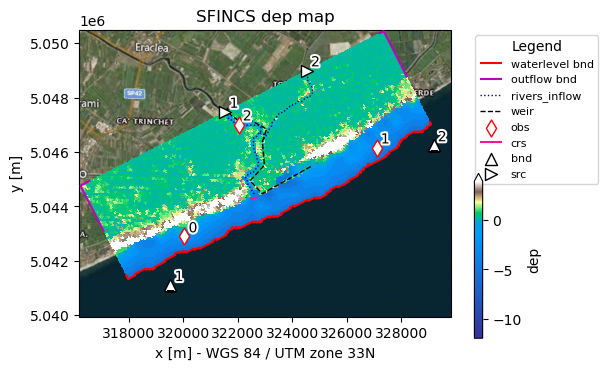

In [27]:
# Use predefined plotting function 'plot_basemap' to show your full SFINCS model setup
_ = sf.plot_basemap(fn_out="basemap.png", bmap="sat", zoomlevel=12)

### 16. Save all files

In [28]:
sf.write()  # write all

In [29]:
# Show created files in folder:
dir_list = os.listdir(sf.root)
print(dir_list)

['figs', 'gis', 'hydromt.log', 'hydromt_data.yml', 'precip_2d.nc', 'run.bat', 'sfincs.bnd', 'sfincs.bzs', 'sfincs.crs', 'sfincs.dis', 'sfincs.ind', 'sfincs.inp', 'sfincs.msk', 'sfincs.obs', 'sfincs.sbg', 'sfincs.scs', 'sfincs.src', 'sfincs.weir', 'subgrid']


Your basemap and forcing figures are saved in the folder 'figs', GIS files (tiff & geojson) of your model setup in 'gis' and merged elevation and manning roughness on subgrid resolution in 'subgrid'.

Now you have made a model, you can progress to the notebook: run_sfincs_model.ipynb